#### Imports

In [16]:
import os
import requests
import pandas as pd
from PIL import Image
import io
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

print("All libraries are successfully imported!")

All libraries are successfully imported!


#### Extract Dataset

In [233]:
# Read the CSV file
file_path = os.path.join(os.getcwd(), "database.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence']
image_pos = df['pos_url']
image_neg = df['neg_url']

new_df = pd.DataFrame({
    'sentence': sentence,
    'image_pos': image_pos,
    'image_neg': image_neg
})

new_df.head()


,sentence,image_pos,image_neg
0,man stand behind the wall,https://previews.123rf.com/images/ryanking999/ryanking9991702/ryanking999170200409/72735211-apuesto-hombre-de-pie-con-pared-de-ladrillo-asi%C3%A1tico.jpg,https://previews.123rf.com/images/ryanking999/ryanking9991703/ryanking999170300165/72844322-hombre-sentarse-y-sentirse-deprimido-con-pared-de-ladrillo-asi%C3%A1tico.jpg
1,The woman is sitting against the wall.,http://www.colourbox.com/preview/5020075-522756-young-woman-sitting-on-the-wooden-floor-against-white-wall.jpg,https://st4.depositphotos.com/1462687/20482/i/1600/depositphotos_204822478-stock-photo-pretty-woman-casual-clothes-sit.jpg
2,Man doing exercise sits in front of a wall,https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/workouts/2017/09/wall-sit-1506433841.gif,https://previews.123rf.com/images/ryanking999/ryanking9991702/ryanking999170200409/72735211-apuesto-hombre-de-pie-con-pared-de-ladrillo-asi%C3%A1tico.jpg
3,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/deagreez2001/deagreez200104071/139177244-full-size-photo-of-gorgeous-brutal-man-stand-isolated-over-grey-wall-background-touch-hand-his-hairc.jpg,https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8E%B0-%E4%BC%81%E4%B8%9A%E5%A4%A7%E5%8E%A6%E5%89%8D%E9%9D%A2%E7%9A%84-%E4%BA%BA%E7%AB%8B%E5%9C%BA-32285543.jpg
4,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/deagreez2001/deagreez200104071/139177244-full-size-photo-of-gorgeous-brutal-man-stand-isolated-over-grey-wall-background-touch-hand-his-hairc.jpg,https://image.shutterstock.com/z/stock-photo-1297043299.jpg


#### Download all images for positive and negative

In [133]:
# Define the folder to save images
save_folder = 'images'
os.makedirs(save_folder, exist_ok=True)

# Read the CSV file
# completed above

pos_indexToRemove = []
neg_indexToRemove = []

# Function to download an image
def download_image(index, url, save_path, indexToRemove):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        img = Image.open(io.BytesIO(response.content))
        img.save(save_path)
        # print(f"Downloaded and saved {url} to {save_path}")
    except requests.exceptions.Timeout:
        print(f"Index: {index} || Timeout: {url} took too long to download.")
        indexToRemove.append(index)
    except Exception as e:
        print(f"Index: {index} || Failed to download {url}: {e}" )
        indexToRemove.append(index)

# Iterate over the URLs in the DataFrame
print("Image Positive")
for index, row in new_df.iterrows():
    url_pos = row['image_pos']  # Replace 'image_url' with the column name in your CSV
    image_name = f"image_pos{index}.jpg"  # You can customize the image naming
    save_path_pos = os.path.join(save_folder, image_name)
    download_image(index, url_pos, save_path_pos, pos_indexToRemove)
print(f"Indicies for positive: {pos_indexToRemove}")

print("Image Negative")
for index, row in new_df.iterrows():
    url_neg = row['image_neg']  # Replace 'image_url' with the column name in your CSV
    image_name = f"image_neg{index}.jpg"  # You can customize the image naming
    save_path_neg = os.path.join(save_folder, image_name)
    download_image(index, url_neg, save_path_neg, neg_indexToRemove)
print(f"Indicies for negative: {neg_indexToRemove}")

print("All images downloaded.")

Image Positive
Index: 2 || Failed to download https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/workouts/2017/09/wall-sit-1506433841.gif: cannot write mode P as JPEG
Index: 5 || Failed to download https://comps.canstockphoto.at/unten-sitzen-wand-junges-schauen-stock-foto_csp18140520.jpg: HTTPSConnectionPool(host='comps.canstockphoto.at', port=443): Max retries exceeded with url: /unten-sitzen-wand-junges-schauen-stock-foto_csp18140520.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x14ad25250>: Failed to resolve 'comps.canstockphoto.at' ([Errno 8] nodename nor servname provided, or not known)"))
Index: 13 || Failed to download https://media.istockphoto.com/photos/man-and-woman-lie-on-a-deserted-sea-beach-and-hug-summer-vacation-picture-id1224829740: 400 Client Error: Bad Request for url: https://media.istockphoto.com/photos/man-and-woman-lie-on-a-deserted-sea-beach-and-hug-summer-vacation-picture-id1224829740
Index: 16 || Failed to download

KeyboardInterrupt: 

Remarks: 22 images failed to download. 

#### Process all images function

In [234]:
def process_image(img, n_components, base_model):
    # Downlaod image
    img = Download_Images(img)

    image = img.resize((224, 224))

    if image.mode != 'RGB':
        # print("Image is greyscale")
        image = image.convert("RGB")

    # Convert the image to an array
    img_array = np.array(image)
    # print("(1) Image shape: ", img_array.shape)

    # Expand dimensions to match the shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the input
    img_array = preprocess_input(img_array)

    # print(f"Raw image data: {img_array}")
    # print(f"(2) Image shape: {img_array.shape}")
    # return(img_array)

    # Extract features 
    features = base_model.predict(img_array)

    # # Define the PCA object
    pca = PCA(n_components=n_components)

    features = features.reshape((features.shape[0], -1))

    # print(f"Image shape for PCA: {features.shape}")
    replicated_feature_vector = np.tile(features, (n_components, 1))
    pca.fit(replicated_feature_vector)
    reduced_vector = pca.transform(features)

    # # print("\nReduced shape:", reduced_vector.shape)
    reshaped_tensor = reduced_vector.reshape(-1)

    return reshaped_tensor

def Download_Images(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

#### TODO: Image vectors

attempt to pre-process input, images removed with error

In [235]:
features_df = new_df.copy()

indicies_to_remove = {2,5,13,16,23,30,55,69,76,88,104,118,122,125,132,137,146,147,153,154,166,181}

for i in indicies_to_remove:
    print(i)
    features_df = features_df.drop(index = i)


2
132
5
69
137
76
13
16
146
147
23
88
153
154
30
166
104
181
118
55
122
125


In [236]:

model = ResNet50(weights='imagenet', include_top=False)

# Iterate through each row in the DataFrame
for index, row in features_df.iterrows():
    print("\nIndex : ", index)
    # Extract the sentence, image_pos, and image_neg from the current row
    sentence_diagram = row['sentence']
    # img_pos = row['image_pos']
    # img_neg = row['image_neg']

    print(" +ve")
    temp_pos = process_image(new_df["image_pos"][index], 16, model)
    features_df.loc[index, "image_pos"] = temp_pos

    # print(" -ve")
    # temp_neg = process_image(new_df["image_neg"][index], 16, model)
    # features_df.loc[index, "image_neg"] = temp_neg

    # temp_pos = process_image(img_pos, 16, model)
    # temp_neg = process_image(img_neg, 16, model)

    # features_df.loc[index, "image_pos"] = temp_pos
    # features_df.loc[index, "image_neg"] = temp_neg

print("Done")


Index :  0
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Index :  1
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Index :  3
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Index :  4
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Index :  6
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Index :  7
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Index :  8
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Index :  9
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

Index :  10
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

Index :  11
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Index :  12
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Index :  14
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

Index :  15
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Index :  17
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

Index :  18
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Index :  19
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Index :  20
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Index :  21
 +ve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [237]:
pd.set_option('display.max_colwidth', None)  # or set it to a specific number of characters
features_df.head()

,sentence,image_pos,image_neg
0,man stand behind the wall,"[6.6329565e-05, 1.4606505e-09, 1.5816681e-10, 9.182655e-13, -4.1738835e-13, -1.6342483e-13, 5.151435e-14, -4.0252246e-12, -9.315215e-12, -1.4210855e-14, -3.499423e-13, 5.1052496e-12, -1.4059864e-12, 4.2632564e-12, -1.5923263e-11, -5.0306426e-11]",https://previews.123rf.com/images/ryanking999/ryanking9991703/ryanking999170300165/72844322-hombre-sentarse-y-sentirse-deprimido-con-pared-de-ladrillo-asi%C3%A1tico.jpg
1,The woman is sitting against the wall.,"[7.8856465e-05, -1.8924844e-09, 1.4460966e-10, -2.1724844e-11, 6.8034467e-12, -1.6882495e-11, 2.4158453e-13, -2.8876457e-11, -1.0459189e-11, -4.4849457e-11, 2.5011104e-12, -6.82121e-13, 4.5758952e-12, -4.6611603e-12, 2.7512215e-11, 3.2969183e-12]",https://st4.depositphotos.com/1462687/20482/i/1600/depositphotos_204822478-stock-photo-pretty-woman-casual-clothes-sit.jpg
3,A man is standing on a wall.,"[7.135191e-05, -5.128531e-10, -1.08144604e-10, -2.3370195e-13, -7.976508e-12, 3.9790393e-13, 6.9722006e-13, 7.887024e-12, -3.2698289e-12, -6.4197536e-12, -5.490719e-12, -4.874323e-12, -8.583356e-12, 2.629008e-13, 1.03419495e-11, 2.5295321e-12]",https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8E%B0-%E4%BC%81%E4%B8%9A%E5%A4%A7%E5%8E%A6%E5%89%8D%E9%9D%A2%E7%9A%84-%E4%BA%BA%E7%AB%8B%E5%9C%BA-32285543.jpg
4,A man is standing on a wall.,"[7.135191e-05, -5.128531e-10, -1.08144604e-10, -2.3370195e-13, -7.976508e-12, 3.9790393e-13, 6.9722006e-13, 7.887024e-12, -3.2698289e-12, -6.4197536e-12, -5.490719e-12, -4.874323e-12, -8.583356e-12, 2.629008e-13, 1.03419495e-11, 2.5295321e-12]",https://image.shutterstock.com/z/stock-photo-1297043299.jpg
6,a person sitting on the wall,"[8.69409e-05, 4.2236454e-09, 5.5251803e-11, 6.581402e-13, 8.7929664e-14, -1.7692514e-12, -7.824852e-13, 8.647305e-12, 5.719869e-13, -3.3129055e-12, -4.2277293e-12, -9.0416563e-13, -4.803269e-12, 7.4251716e-13, -1.180922e-11, 3.9364068e-11]",https://c0.anyrgb.com/images/795/432/human-person-kid-hide-and-seek-climbing-caucasian-child-denim-playing-sit.jpg


In [238]:
features_df.head()

,sentence,image_pos,image_neg
0,man stand behind the wall,"[6.6329565e-05, 1.4606505e-09, 1.5816681e-10, 9.182655e-13, -4.1738835e-13, -1.6342483e-13, 5.151435e-14, -4.0252246e-12, -9.315215e-12, -1.4210855e-14, -3.499423e-13, 5.1052496e-12, -1.4059864e-12, 4.2632564e-12, -1.5923263e-11, -5.0306426e-11]",https://previews.123rf.com/images/ryanking999/ryanking9991703/ryanking999170300165/72844322-hombre-sentarse-y-sentirse-deprimido-con-pared-de-ladrillo-asi%C3%A1tico.jpg
1,The woman is sitting against the wall.,"[7.8856465e-05, -1.8924844e-09, 1.4460966e-10, -2.1724844e-11, 6.8034467e-12, -1.6882495e-11, 2.4158453e-13, -2.8876457e-11, -1.0459189e-11, -4.4849457e-11, 2.5011104e-12, -6.82121e-13, 4.5758952e-12, -4.6611603e-12, 2.7512215e-11, 3.2969183e-12]",https://st4.depositphotos.com/1462687/20482/i/1600/depositphotos_204822478-stock-photo-pretty-woman-casual-clothes-sit.jpg
3,A man is standing on a wall.,"[7.135191e-05, -5.128531e-10, -1.08144604e-10, -2.3370195e-13, -7.976508e-12, 3.9790393e-13, 6.9722006e-13, 7.887024e-12, -3.2698289e-12, -6.4197536e-12, -5.490719e-12, -4.874323e-12, -8.583356e-12, 2.629008e-13, 1.03419495e-11, 2.5295321e-12]",https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8E%B0-%E4%BC%81%E4%B8%9A%E5%A4%A7%E5%8E%A6%E5%89%8D%E9%9D%A2%E7%9A%84-%E4%BA%BA%E7%AB%8B%E5%9C%BA-32285543.jpg
4,A man is standing on a wall.,"[7.135191e-05, -5.128531e-10, -1.08144604e-10, -2.3370195e-13, -7.976508e-12, 3.9790393e-13, 6.9722006e-13, 7.887024e-12, -3.2698289e-12, -6.4197536e-12, -5.490719e-12, -4.874323e-12, -8.583356e-12, 2.629008e-13, 1.03419495e-11, 2.5295321e-12]",https://image.shutterstock.com/z/stock-photo-1297043299.jpg
6,a person sitting on the wall,"[8.69409e-05, 4.2236454e-09, 5.5251803e-11, 6.581402e-13, 8.7929664e-14, -1.7692514e-12, -7.824852e-13, 8.647305e-12, 5.719869e-13, -3.3129055e-12, -4.2277293e-12, -9.0416563e-13, -4.803269e-12, 7.4251716e-13, -1.180922e-11, 3.9364068e-11]",https://c0.anyrgb.com/images/795/432/human-person-kid-hide-and-seek-climbing-caucasian-child-denim-playing-sit.jpg


#### TODO: Split THE TRAIN, DEV, TEST

#### Sentence DisCoCat 

remove the articles from a sentence

this is in a quantum setting but it might be more efficient in a a tensor setting

↓ sample sentence diagram


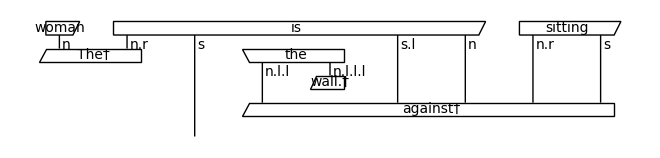

In [243]:
from lambeq import BobcatParser, AtomicType, Sim14Ansatz, RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

# Parse the sentence and convert it into a string diagram
sentences = features_df["sentence"]

# Use BobbcatParser
parser = BobcatParser(verbose='suppress')
raw_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in sentences]
ansatz_sentence = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},n_layers=1)
# sentence_diagram.draw(figsize=(14, 3), fontsize=12)

train_diagrams_sentence = [remove_cups(diagram) for diagram in raw_sentence_diagrams]
print('↓ sample sentence diagram')
train_diagrams_sentence[1].draw()

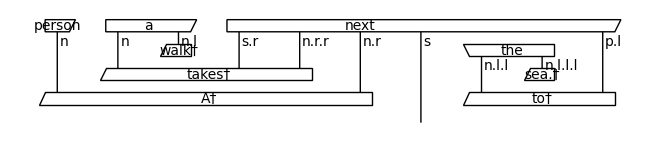

KeyError: Ty(n)

In [251]:
train_diagrams_sentence[43].draw()

diag = train_diagrams_sentence[43]
x = ansatz(diag)

In [252]:
# features_df['sentence'] = features_df['sentence'].astype('string')
train_circuits_sentence = [ansatz_sentence(diagram) for diagram in train_diagrams_sentence]
print('↓ sample sentence circuit')
train_circuits_sentence[1].draw(figsize=(30, 20), fontsize=12)

KeyError: Ty(p)

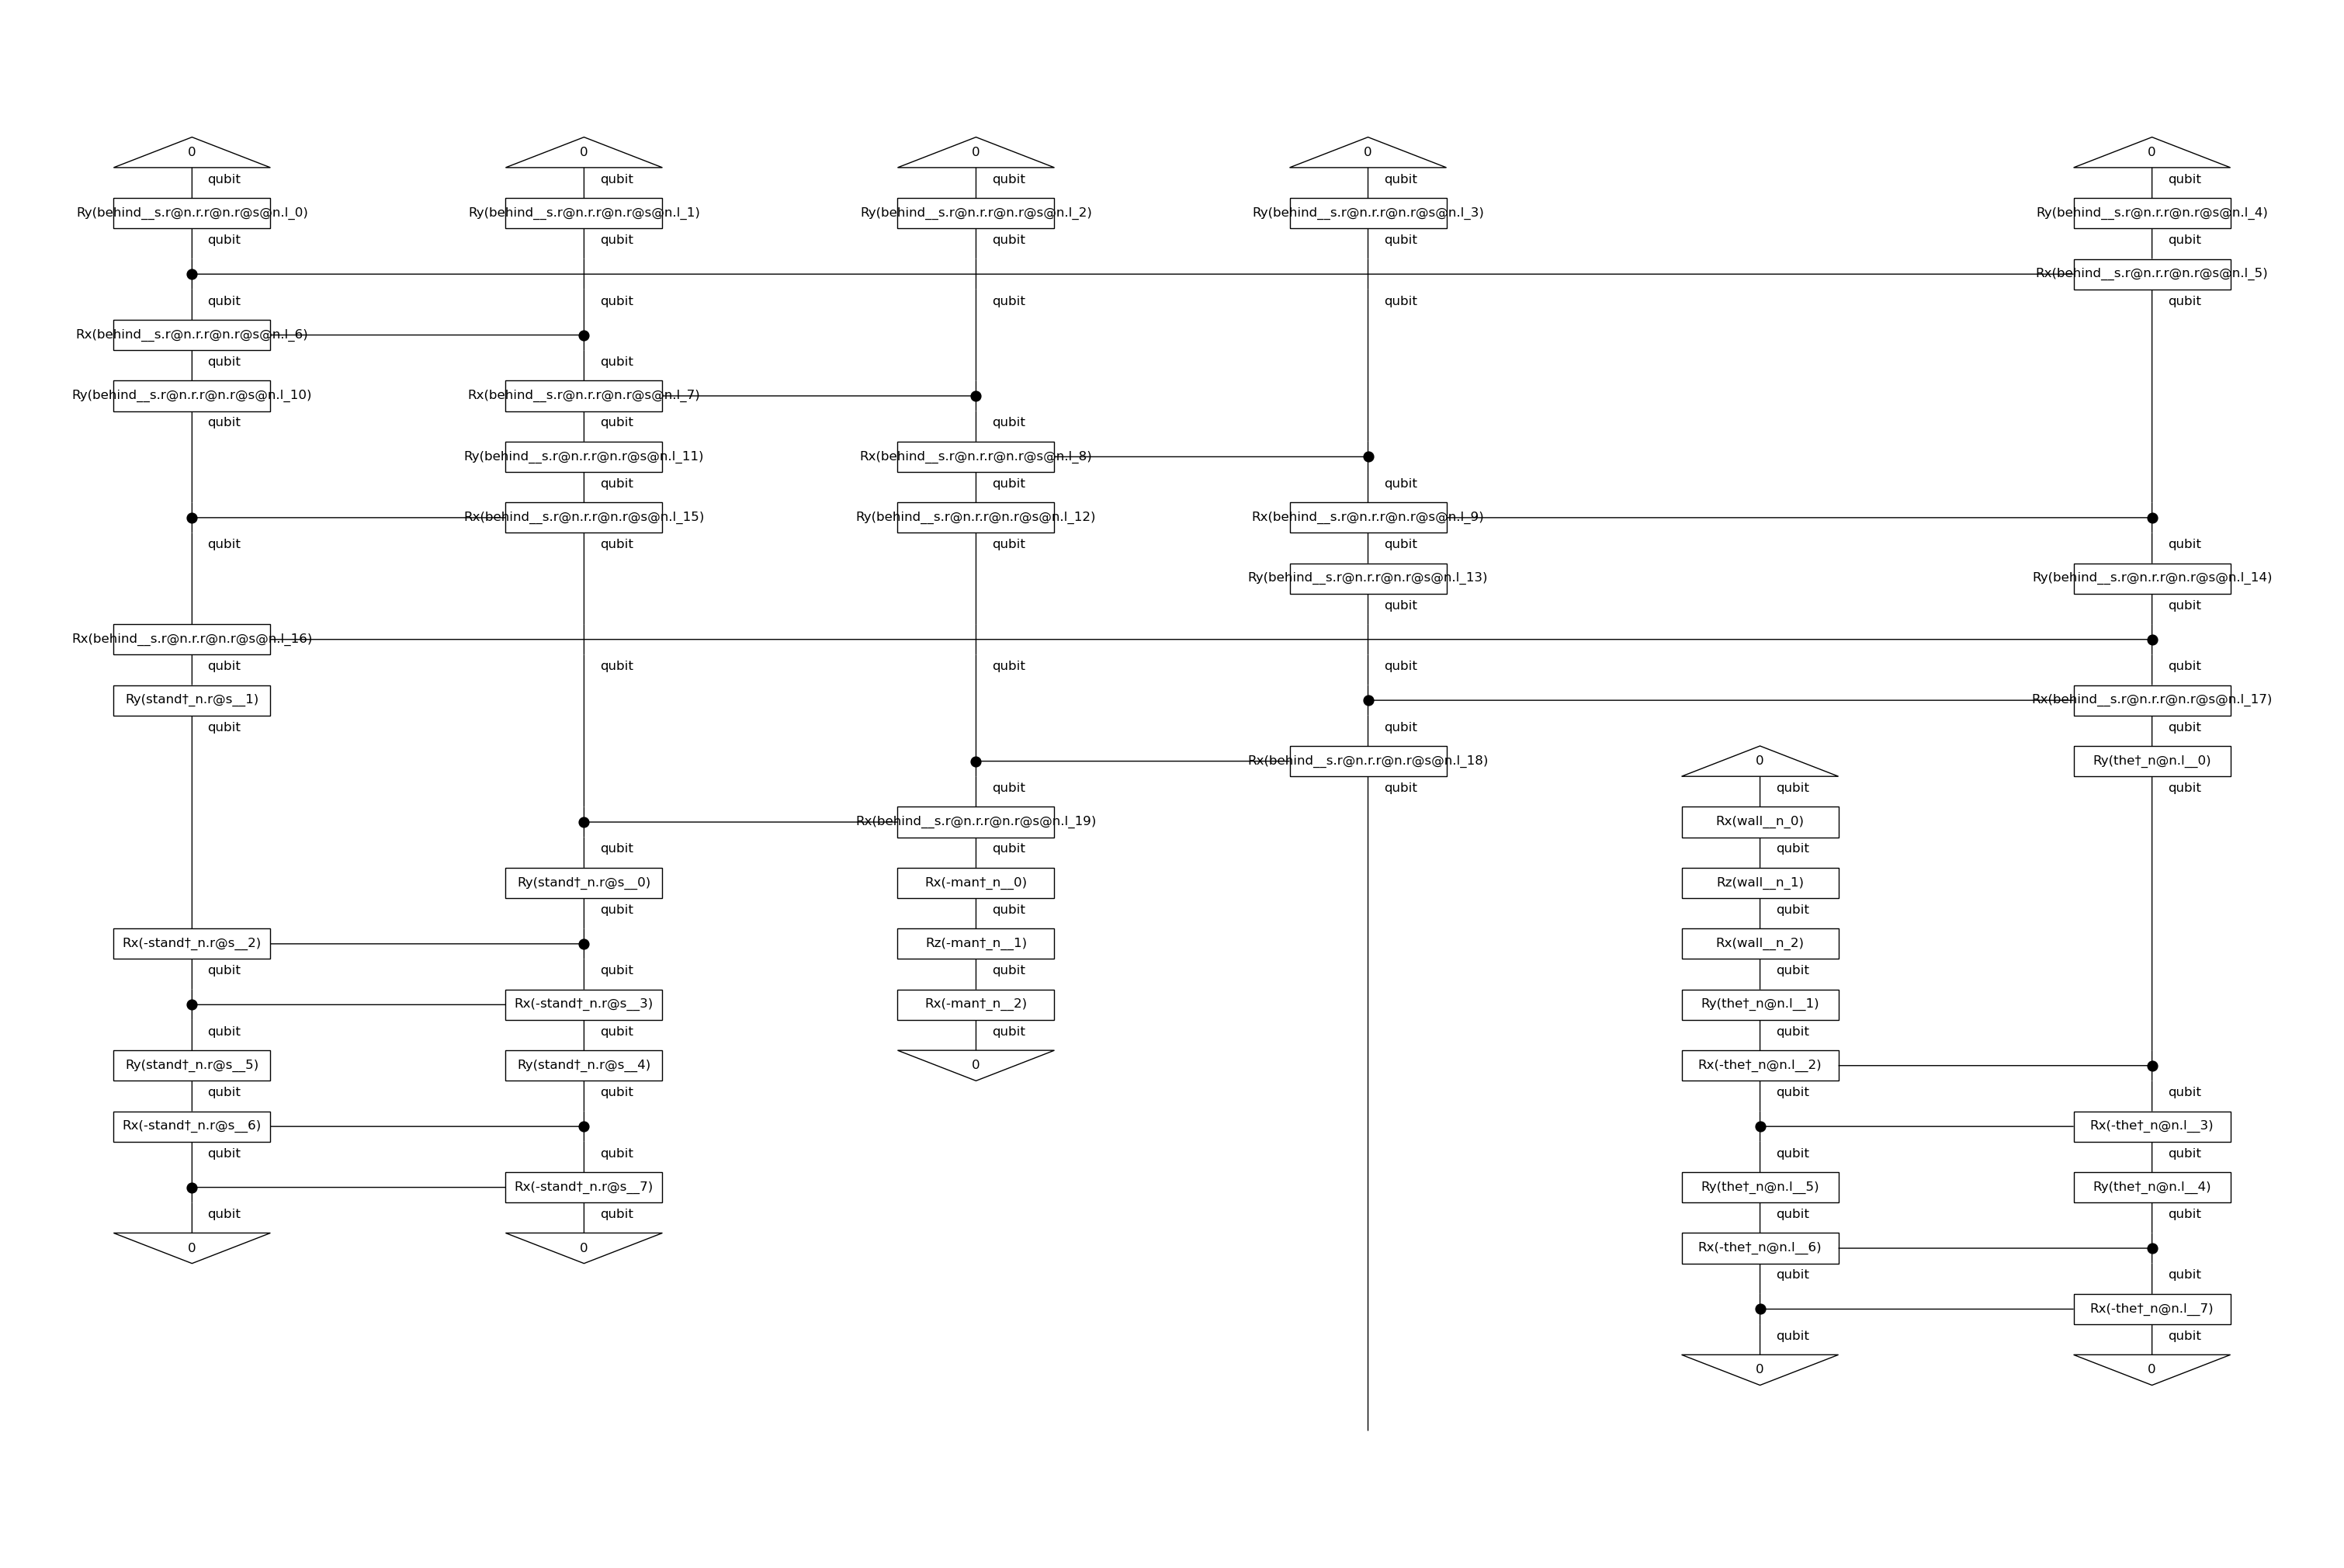

In [232]:
train_circuits_sentence[43].draw(figsize=(30, 20), fontsize=12)

#### Create two seperate ansatz image circuit

In [183]:
# Make the numpy arrays in image pos into a list
# ORGANIZE AND MAKE THIS EARLIER

copy_df = features_df.copy()
list_of_lists = copy_df['image_pos'].apply(lambda x: x.tolist()).tolist()

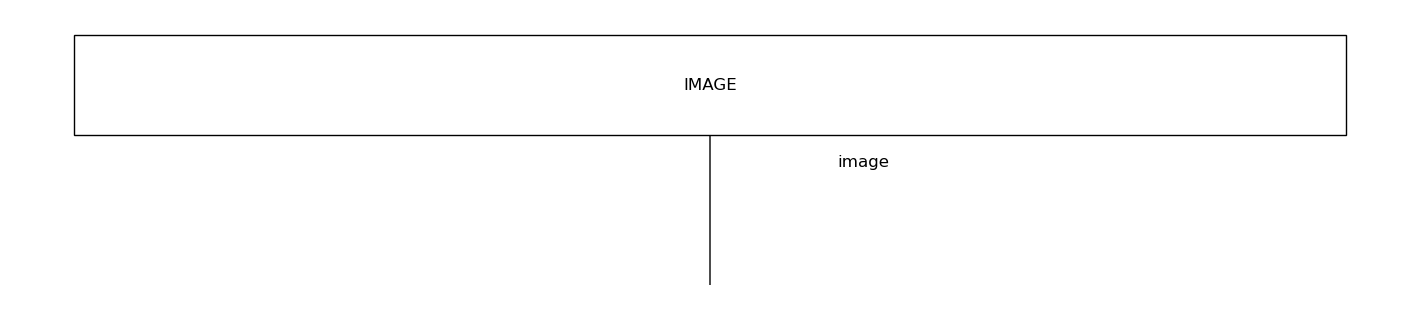

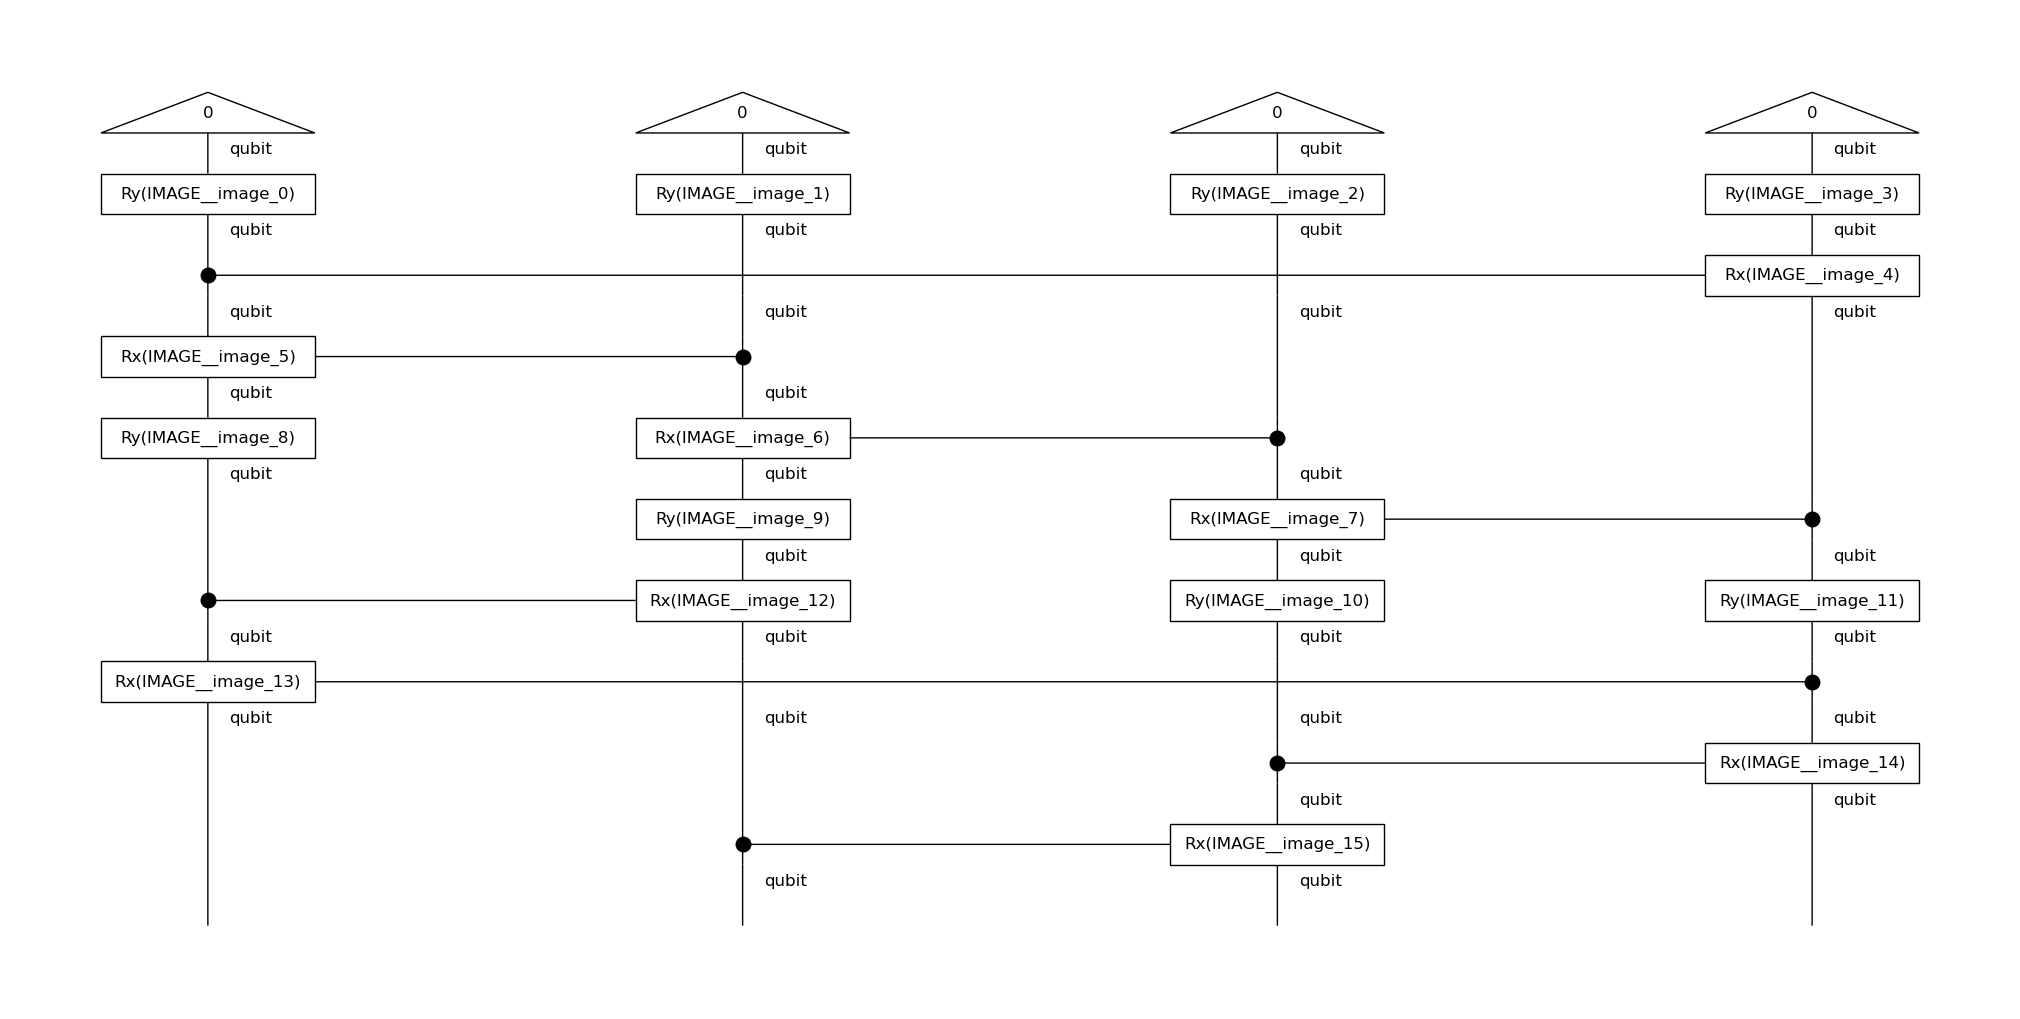

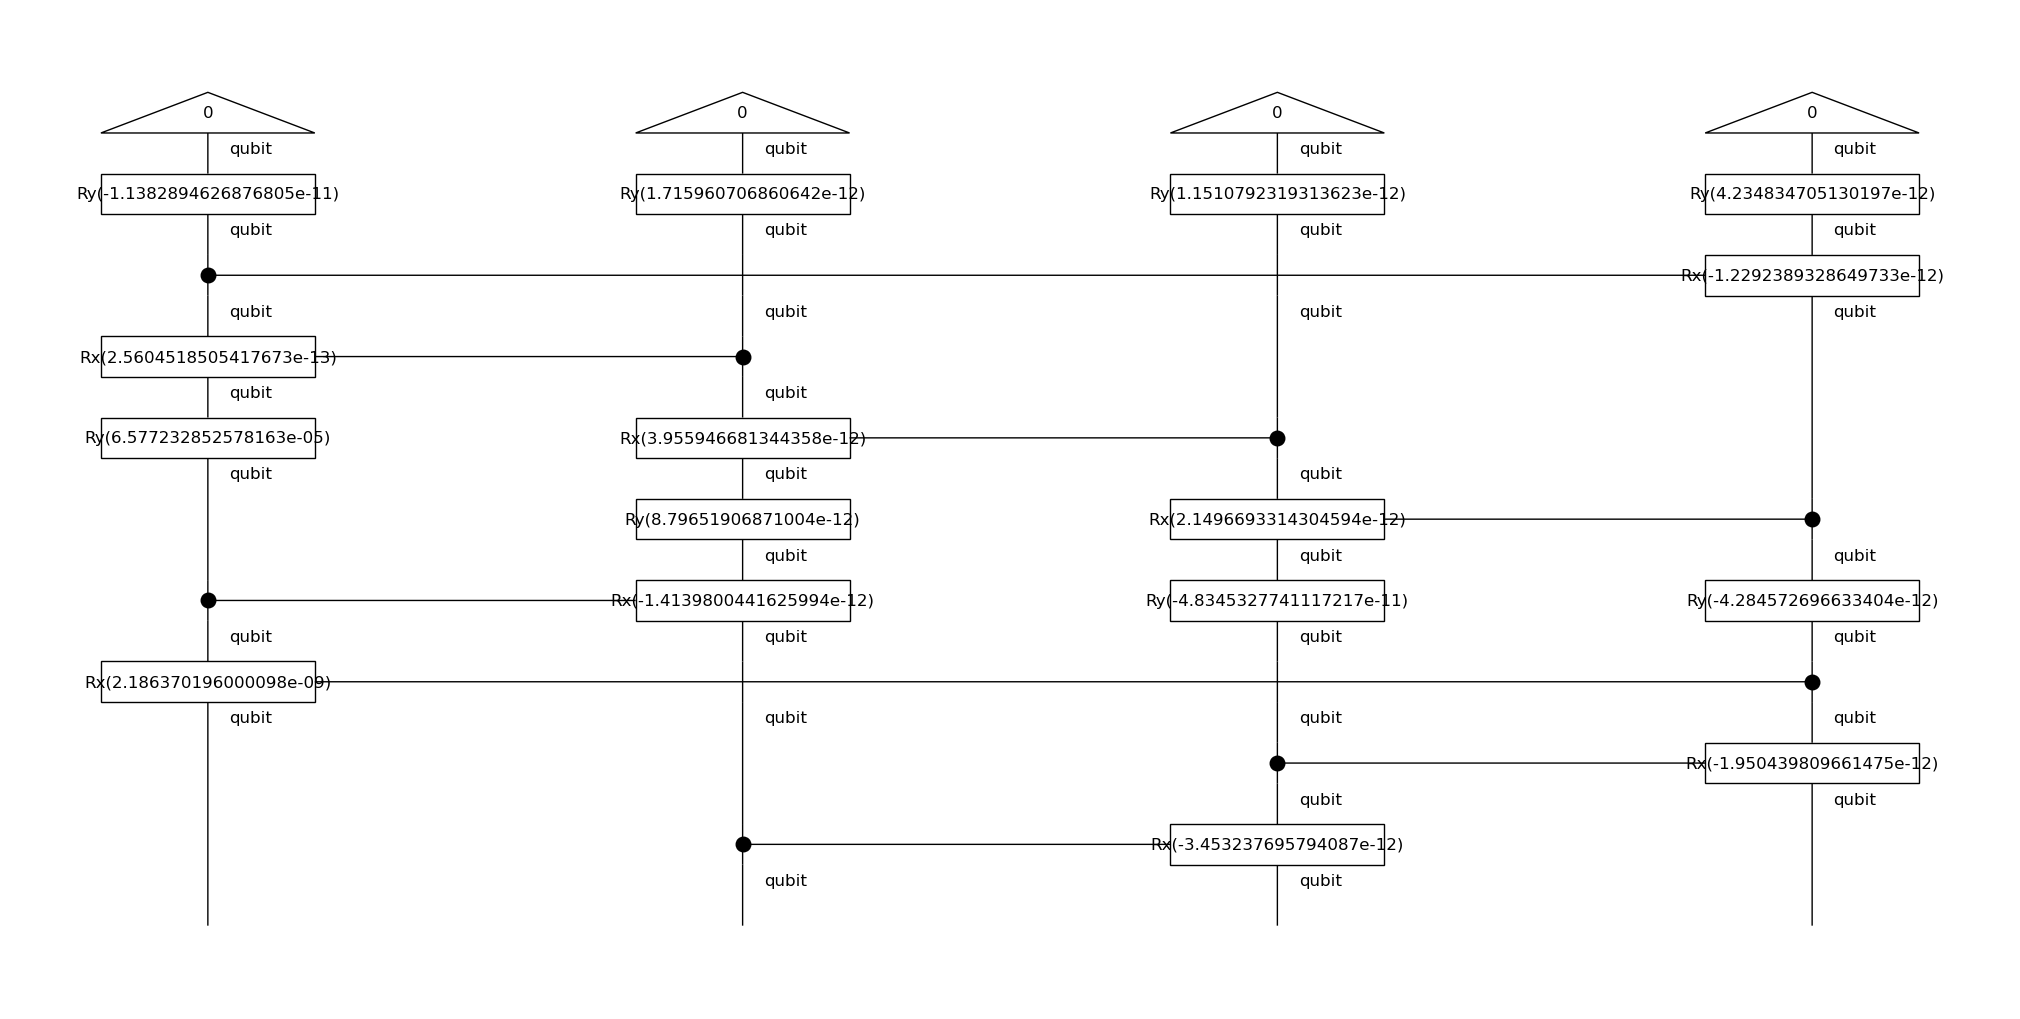

In [231]:
from lambeq.backend.grammar import Ty, Box 
from lambeq import Sim14Ansatz
from torch import nn

# Create a new image Ty
image_type = Ty("image")
image_box = Box(name = "IMAGE", dom = Ty(), cod= image_type)
image_box.draw(figsize=(14, 3), fontsize=12)

# Create template Ansatz
ansatz = Sim14Ansatz({image_type: 4}, n_layers=1)
image_circ = ansatz(image_box)
image_circ.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit POS
images = copy_df["image_pos"]
train_circuits_imagePos = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in images]
train_circuits_imagePos[9].draw(figsize=(20, 10), fontsize=12)

# POSITIVE AND NEGATIVE IMAGES
# conc_image_circ_pos = image_circ.lambdify(*list(image_circ.free_symbols))(*vector) 
# conc_image_circ_pos.draw(figsize=(20, 10), fontsize=12)
# conc_image_circ_neg = image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec_neg) 
# conc_image_circ_neg.draw(figsize=(20, 10), fontsize=12)

#### Joined senetnce and image 

Template diagram : (sentence, image1, image2)
Template circuit : (sentence, image_type , image_type)


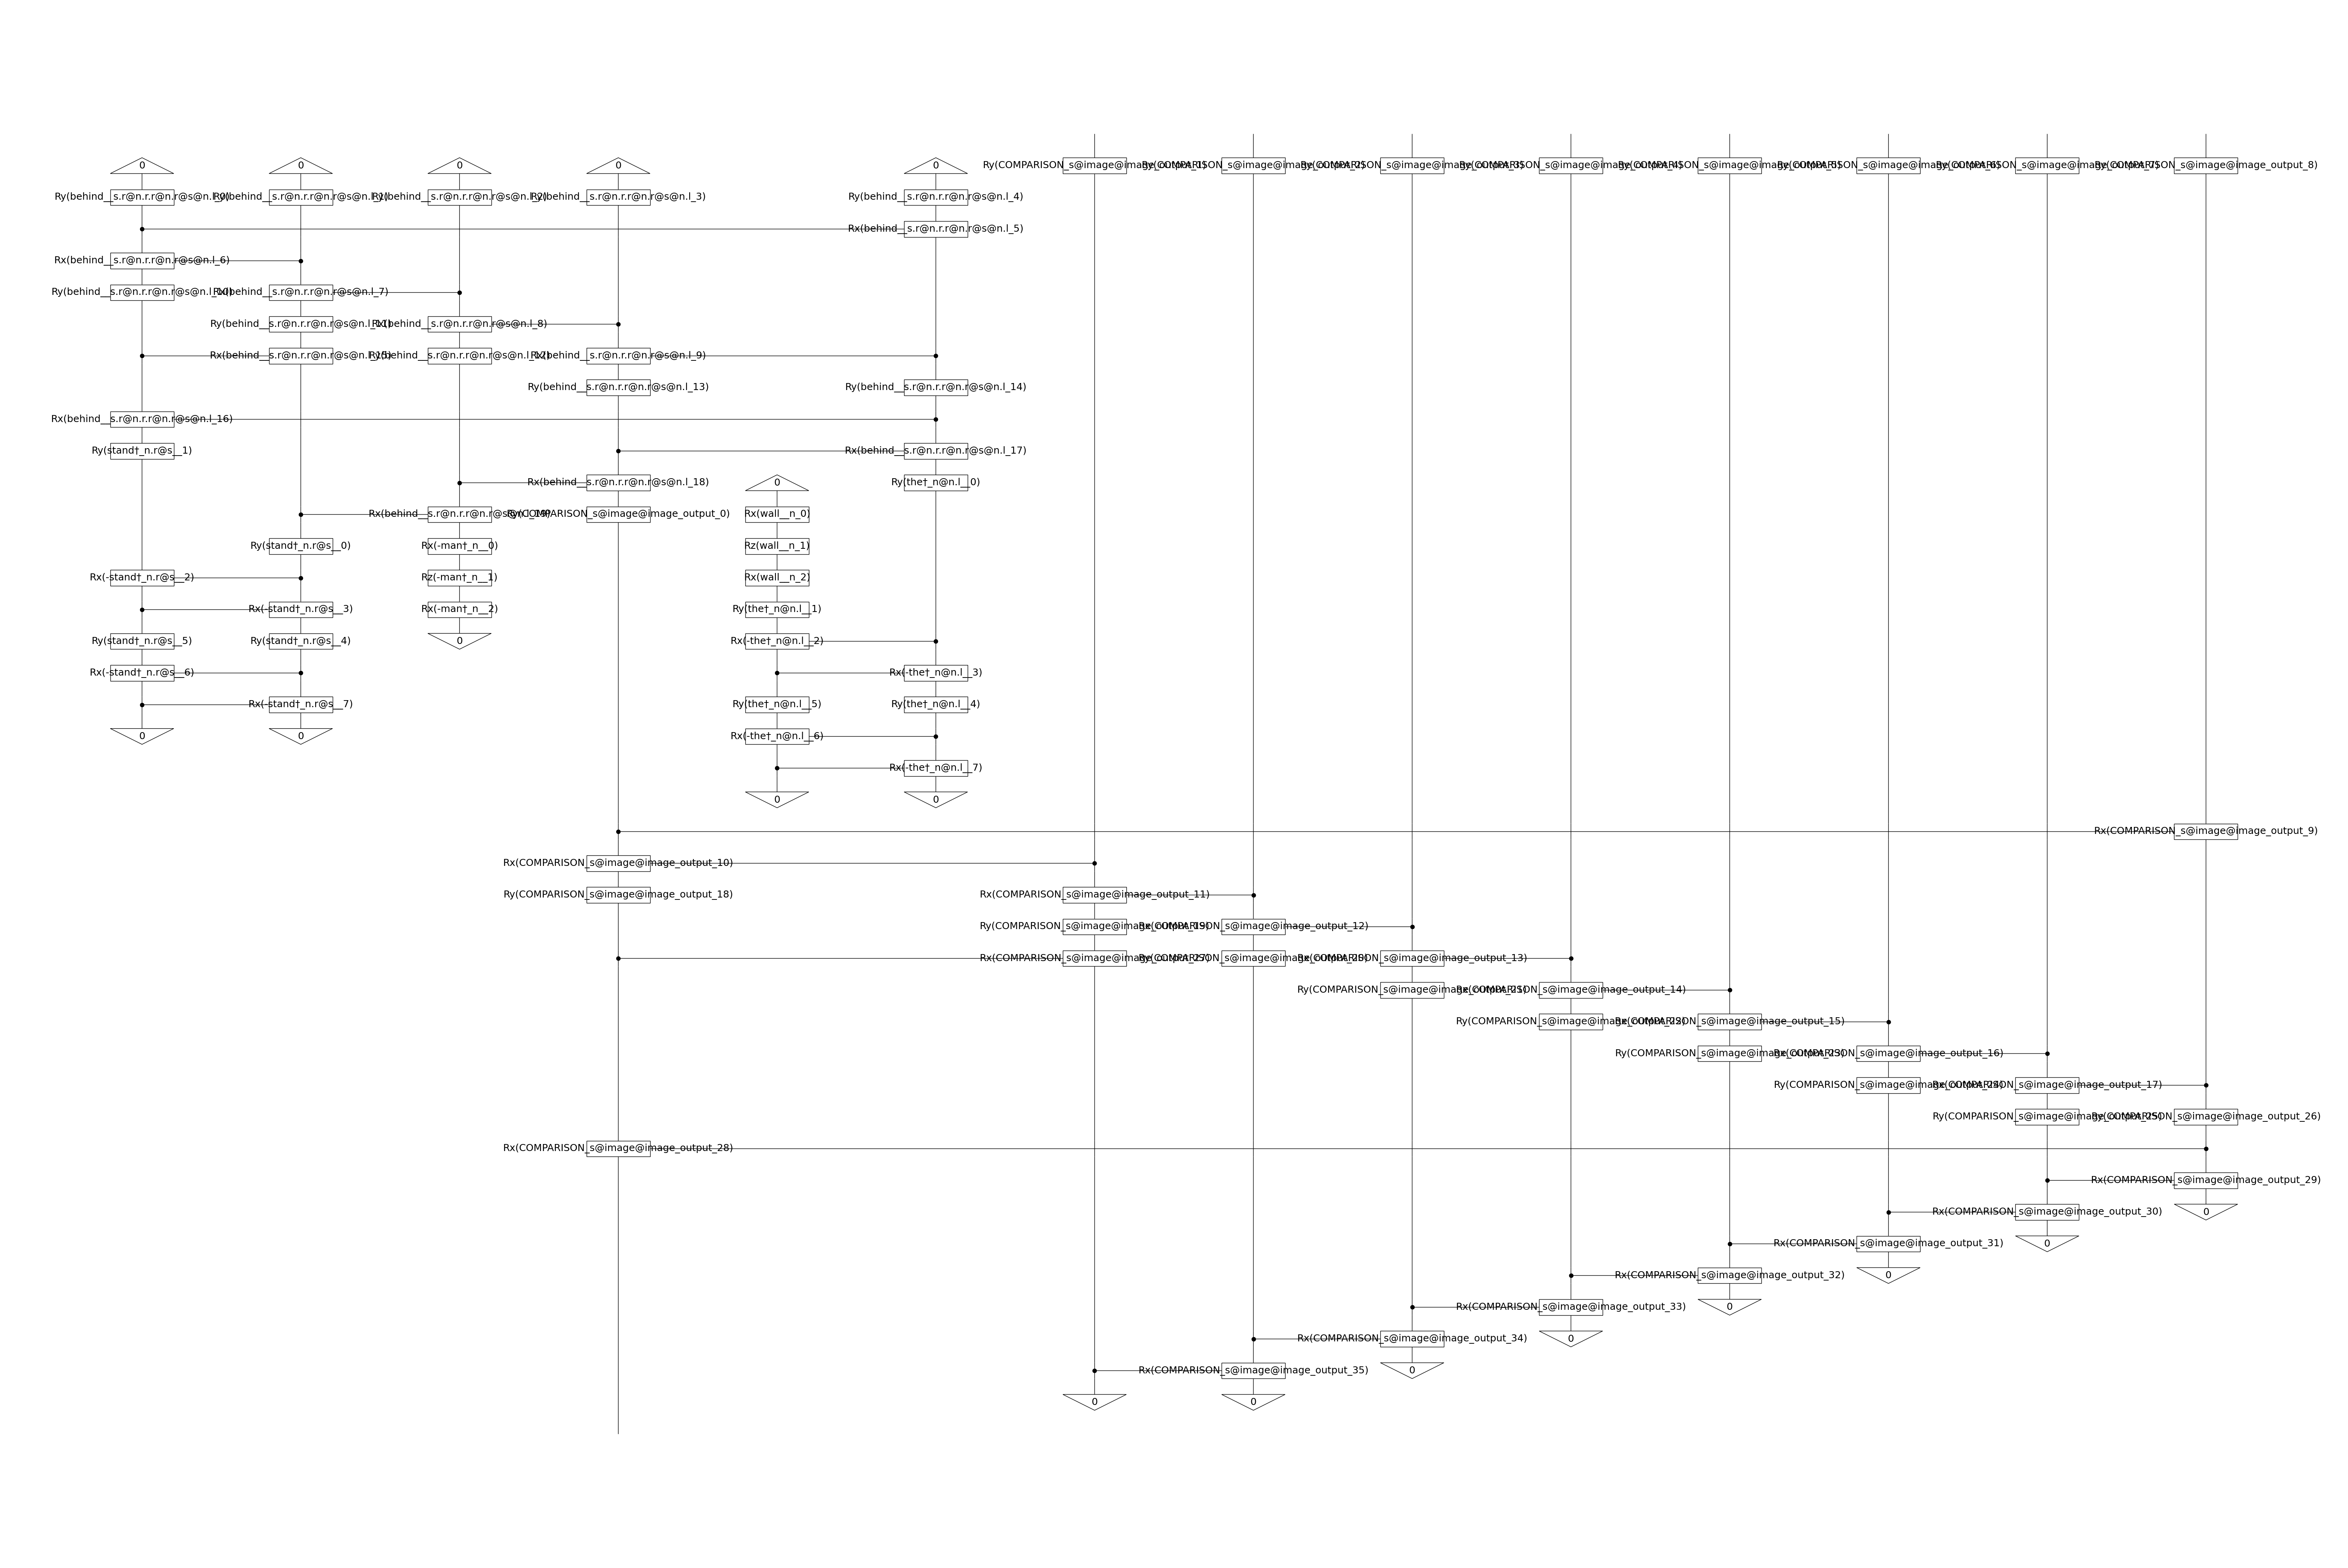

In [223]:
# Create new Type
image_type = Ty("image")
output_type = Ty("output")
comparison_box = Box("COMPARISON", AtomicType.SENTENCE @ image_type @ image_type, output_type)

# Draws diagram with comparison box (0,1)
# Sentence digarm and comparison box is in grammar form
diagrams = ((sentence_diagram @ image_type @ image_type) >> comparison_box for sentence_diagram in train_diagrams_sentence)
print("Template diagram : (sentence, image1, image2)")
# temp_diagram.draw(figsize=(20, 10), fontsize=12)

# Ansatz & Circuit
ansatz = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, image_type : 4, output_type : 1},  n_layers=1)
temp_circuit = [ansatz(diagram) for diagram in diagrams]

print("Template circuit : (sentence, image_type , image_type)")
temp_circuit[3].draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )


Sample quantum circuit : (sentence, image data pos , image data neg)


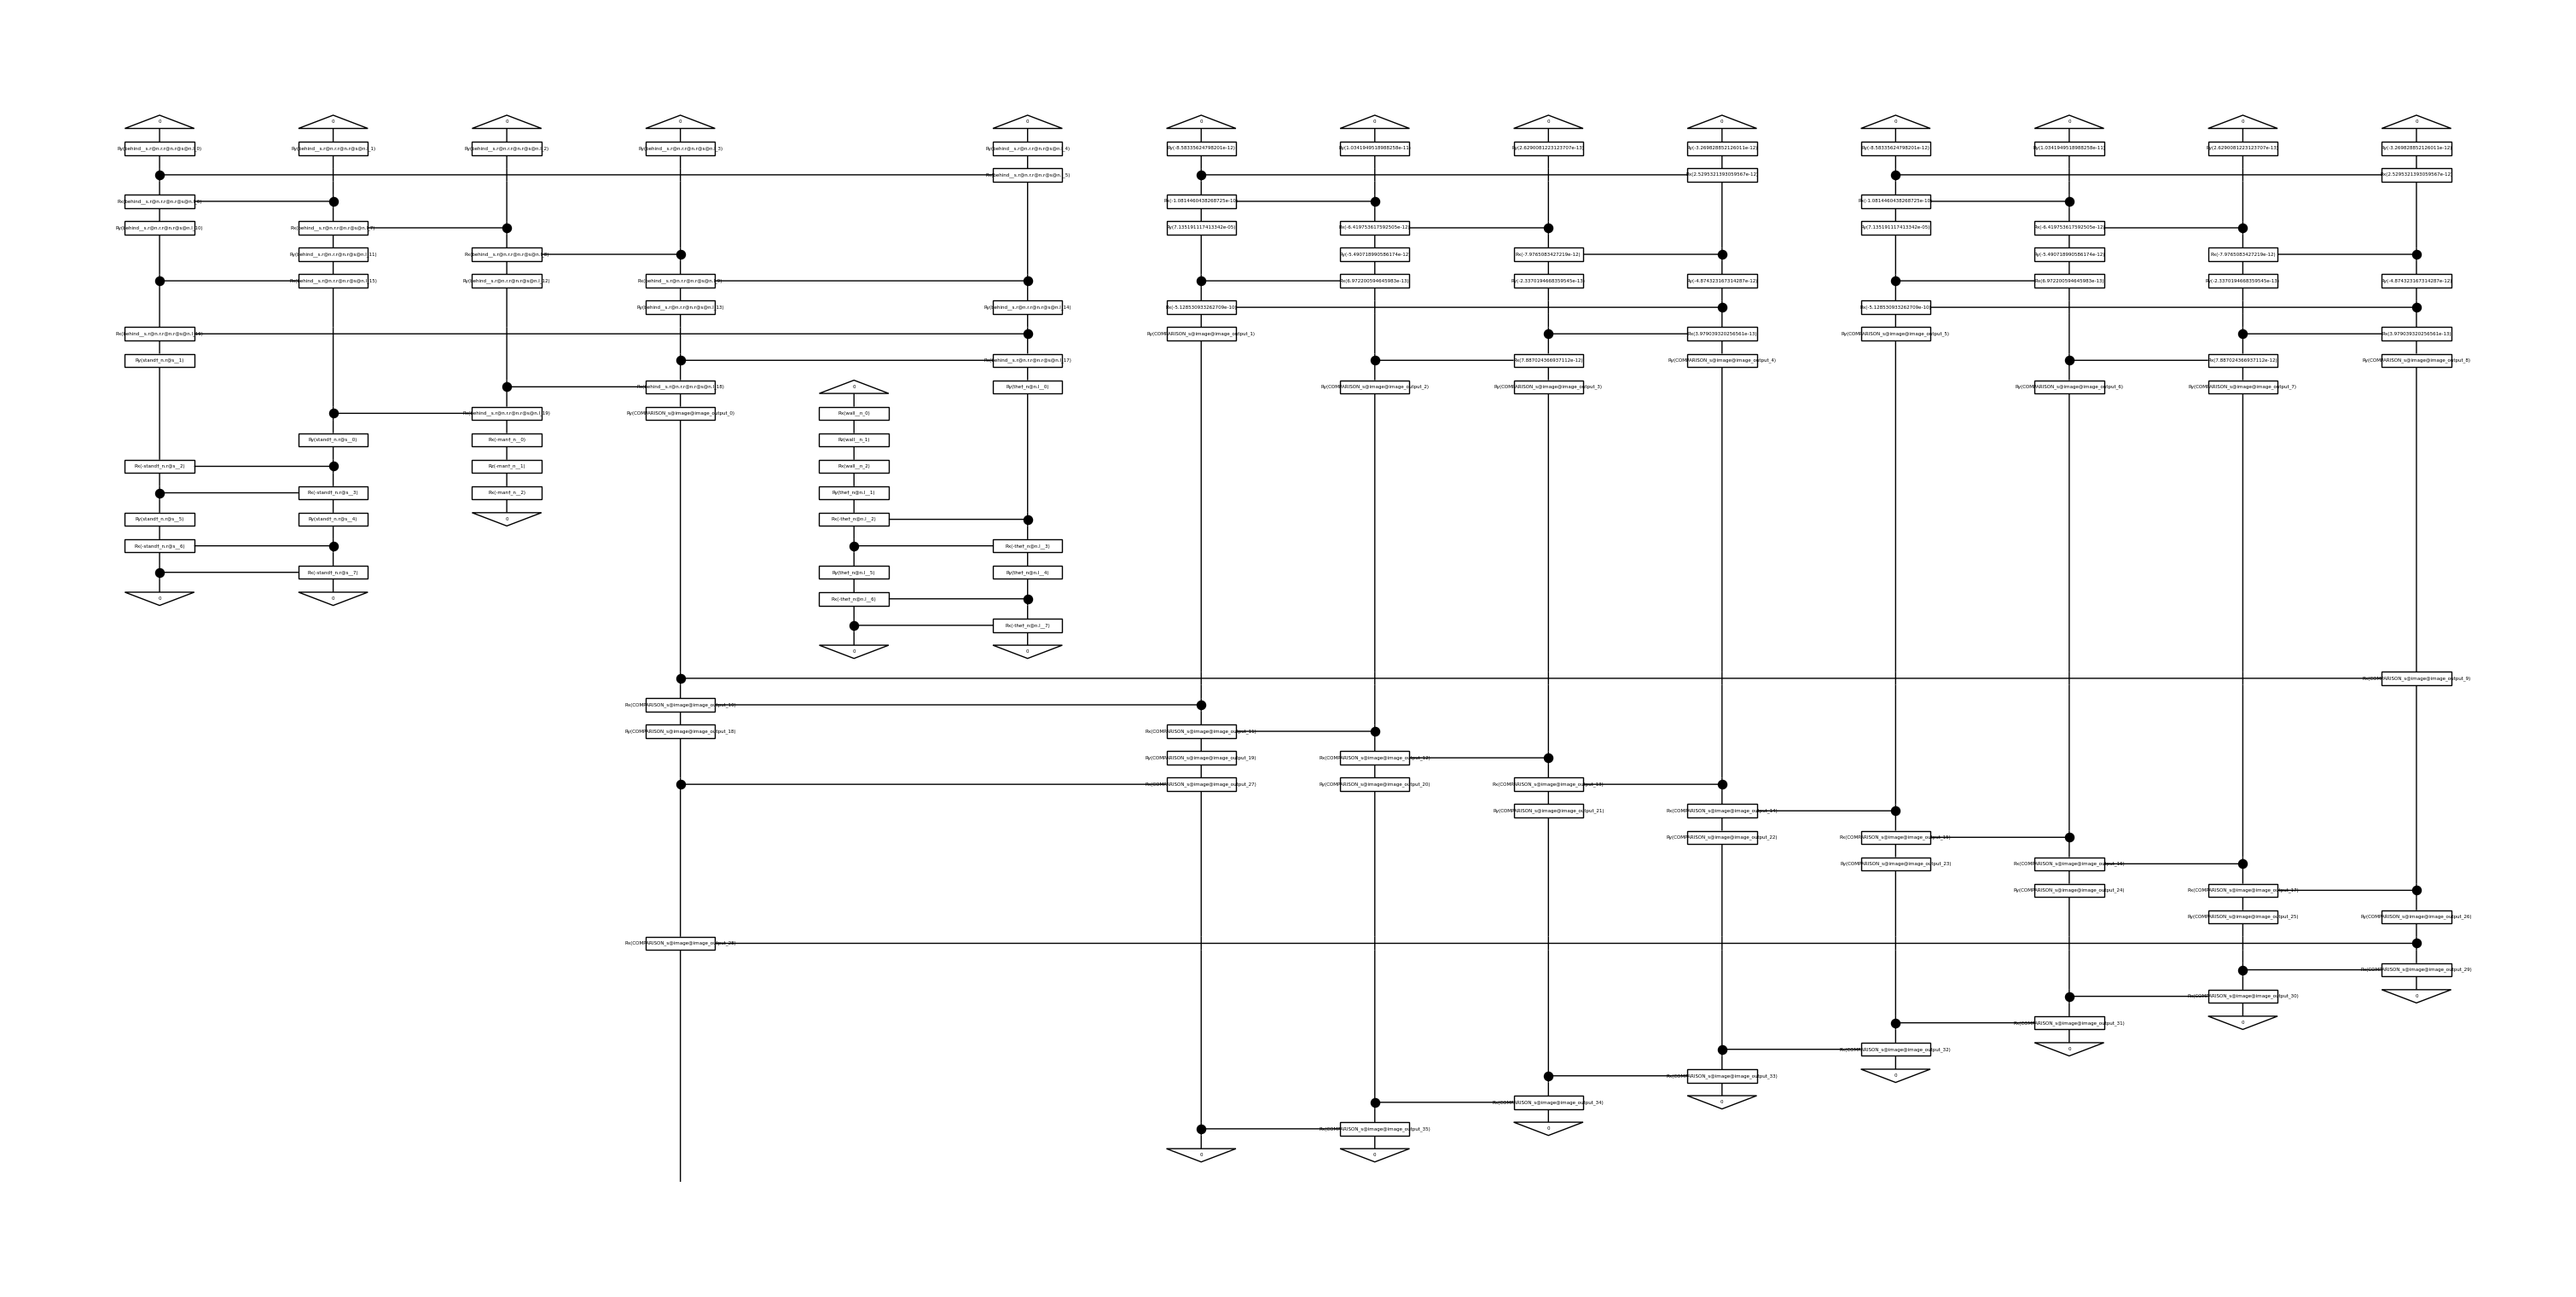

In [230]:
image_1 = train_circuits_imagePos
image_2 = train_circuits_imagePos

# final_circuit = image_1 @ image_2 >> temp_circuit

final_circuit = [(image_1[index] @ image_2[index] >> temp_circuit[index]) for index in range(len(features_df))]
print("Sample quantum circuit : (sentence, image data pos , image data neg)")
final_circuit[2].draw(figsize=(30, 15), fontsize=4, draw_type_labels = False )
